In [1]:
from keras.datasets.imdb import get_word_index
from keras.datasets import imdb 
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, LSTM,Dense, GRU
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import os
from matplotlib import pyplot as plt
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [2]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=10000)

word_index_dictionary = get_word_index()


print(len(x_train),'train sequences')
print(len(x_test),'test sequences')
print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train,maxlen=500) ## max 500 words per sample (review)
x_test = sequence.pad_sequences(x_test,maxlen=500)    
print(x_train.shape,'x_train shape')
print(x_test.shape,'x_test shape')


25000 train sequences
25000 test sequences
Pad sequences (samples x time)
(25000, 500) x_train shape
(25000, 500) x_test shape


Every sample within a batch must share the same parameters,unless batch_size = 1 (I.E sequence length)
Not all sentences have to be the same length within a batch, though zero-padding still required before feeding into RNN. 
e.g: "Hello how is your day? 0 0 0 0"-"Good, I'm fine thank you for asking"


For our guitar application, do we want a sample to represent a song or an image? batch_size of 1? stateless or stateful i.e: state of RNN not reset after new batch.  

#  LSTM RNN

In [6]:
model = Sequential()
model.add(Embedding(10000,32)) ## Embedding layer turning positive integers into scale of [-1,1]
model.add(SimpleRNN(32)))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=5,
batch_size=128,
validation_split=0.2)




C:\Users\Gebruiker\miniconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 21s 1ms/step - loss: 0.6367 - acc: 0.6285 - val_loss: 0.5290 - val_acc: 0.7402
Epoch 2/5
20000/20000 [==============================] - 25s 1ms/step - loss: 0.4144 - acc: 0.8229 - val_loss: 0.4245 - val_acc: 0.8154
Epoch 3/5
20000/20000 [==============================] - 27s 1ms/step - loss: 0.3030 - acc: 0.8760 - val_loss: 0.4520 - val_acc: 0.7848
Epoch 4/5
20000/20000 [==============================] - 30s 2ms/step - loss: 0.2264 - acc: 0.9131 - val_loss: 0.3983 - val_acc: 0.8276
Epoch 5/5
20000/20000 [==============================] - 29s 1ms/step - loss: 0.1548 - acc: 0.9459 - val_loss: 0.5754 - val_acc: 0.7976


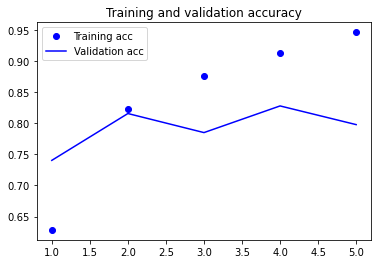

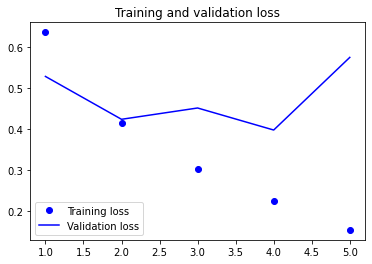

In [8]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
    

In [12]:
data_dir = 'D:\Downloads\jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))
temp = float_data[:, 1]  #<1> temperature (in degrees Celsius)
plt.plot(range(1440), temp[:1440])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


NameError: name 'float_data' is not defined

In [8]:
float_data = np.zeros((len(lines), len(header) - 1)) ##CSV FILE ROWS TO NUMPYArray
for i, line in enumerate(lines):
        values = [float(x) for x in line.split(',')[1:]]
        float_data[i, :] = values    
        
mean = float_data[:200000].mean(axis=0)  ##rescaling all data in numpyArrray
                                         # the same scale(normal distribution) 
                                         # so that NN can easier learn patterns
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std        

NameError: name 'lines' is not defined

In [6]:
def generator(data, lookback, delay, min_index, max_index,
             shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets ## Data is scooped from CSV 
                               ## and delivered in tuple form (samples,targets)

# Custom Generators

In [7]:
lookback = 1440
step = 6
delay = 144 
batch_size = 128
                ## Creating generators to choose how the data is scooped from
                ## the numpyarray(csvfile) and kept in our hand
        
train_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size) # how many samples (batch_size) drawn and
                                           # held in in memmory when feeding into NN

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size

test_steps = (len(float_data) - 300001 - lookback) // batch_size

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
steps_per_epoch=500, ## how many scoops (batches) drawn; how many times the Generator called
epochs=20,
validation_data=val_gen,
validation_steps=val_steps)

NameError: name 'float_data' is not defined

#  GRU RNN

In [1]:
model = Sequential()
model.add(layers.GRU(32,input_shape=(None,float_data.shape[-1])))
model.add(Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=20,
                            validation_data=val_gen,
                            validation_steps=val_steps)


NameError: name 'Sequential' is not defined

# Bidirectional GRU 

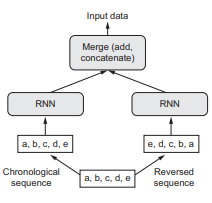

In [4]:
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(
num_words=max_features)
x_train = [x[::-1] for x in x_train] ##reversing data
x_test = [x[::-1] for x in x_test]   ## 
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential() 
model.add(layers.Bidirectional(
layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1)) ## Learning  potential patterns both ways in time
                           ## clock-wise and counter-clock-wise

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=40,
                            validation_data=val_gen,
                            validation_steps=val_steps)

NameError: name 'float_data' is not defined

In [ ]:

model = Sequential() 
model.add(layers.GRU(32,)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()